In [1]:
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM,Dense,Conv2D,MaxPooling2D,Flatten,Embedding,GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

### Loading and Preparing  Dataset


In [6]:
image_dir = 'Flickr8k/Flicker8k_Dataset/'
caption_file = 'Flickr8k/Flickr8k.token.txt'

In [7]:
#Loading Captions for each image
captions = open(caption_file,'rb').read().decode(encoding='utf-8')
captions = captions.split('\n')

In [8]:
captions[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [9]:
image_fname = []
image_captions = []
start_token = '<start> ' #token for starting each caption
end_token = ' <end>' #end token to end each caption
for line in captions:
    line=re.sub(r'[\t,\n]','',line)
    line=re.split('#[0-9]', line) #separating filename and captions
    fname = line[0]
    caps = line[1].lower()
    caps = re.sub(r'[!"#$%&()*+.,-/:;=?@[\]^_`{|}~0123456789\']', '', caps)
    caps = re.sub(r'[ +]', ' ',caps)
    image_fname.append(image_dir+fname)
    image_captions.append(start_token+caps+end_token)
    

    

In [10]:
image_captions[:5]

['<start> a child in a pink dress is climbing up a set of stairs in an entry way  <end>',
 '<start> a girl going into a wooden building  <end>',
 '<start> a little girl climbing into a wooden playhouse  <end>',
 '<start> a little girl climbing the stairs to her playhouse  <end>',
 '<start> a little girl in a pink dress going into a wooden cabin  <end>']

In [11]:
total_captions = (len(image_captions))
print(total_captions)

40455


In [12]:
#Building corpus text
text = ' '.join(image_captions)
vocab= sorted(set(text.split(' ')))
vocab.remove('')

In [13]:
#total vocab in the corpus
total_vocab = len(vocab)
print(total_vocab)

8780


In [14]:
#Building vocabulary only with most common words
#Keeping the words that appear more than 5 times in corpus
vocab_list = []
for word in vocab:
    word_count = text.count(word)
    if word_count >5 :
        vocab_list.append(word)

In [15]:
#adding index for unkown words in the vocabulary list and for padding
vocab_list.insert(0,'<pad>')
vocab_list.insert(1,'<unk>')

In [16]:
#vocab size for training our model
vocab_size = len(vocab_list)
print(vocab_size)

3435


In [17]:
wrd2idx={ch:i for i,ch in enumerate(vocab_list)}
idx2wrd={i:ch for i,ch in enumerate(vocab_list)}

In [18]:
#Tokenizing captions with integers for training
caption_sequences=[]
for caption in image_captions:
    caption_sequences.append([wrd2idx[i] if i in wrd2idx.keys() else wrd2idx['<unk>'] for i in caption.split(' ')]) 

In [19]:
#Separating Sequences for Training and Test set, Using 32000 samples from dataset for training
train_image_path = image_fname [:32000]
train_captions  = caption_sequences [:32000]
test_image_path = image_fname[32000:]
test_captions = caption_sequences[32000:]

In [20]:
#Padding Train set so that input of each sequence is same length
pad_train_caps = pad_sequences(train_captions, padding='post')

In [21]:
def split_input_target(chunk):
    '''
    Creates input & output label for training the data.
    chunk -- text to be processed for creating input output data
    input_text -- list of training data
    output_text -- list of output data
    '''
    input_text = chunk[:-1]
    output_text = chunk
    return input_text, output_text

def load_and_preprocess_image(path):
    '''
    Reads images for the location for training
    '''
    image = tf.io.read_file(path)
    return preprocess_image(image)

def preprocess_image(image):
    '''
    Processing images before passing to model
    '''
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = image/255.0   
    return image

def prepare_data(image_path, pad_captions):
    '''
    Used to map, the image and related caption
    Used with tf.data.Dataset
    '''
    image = load_and_preprocess_image(image_path)
    x_text,y_text = split_input_target(pad_captions)
    return image,x_text,y_text

In [22]:
#Creating Training dataset with tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_path, pad_train_caps))
train_dataset = train_dataset.map(prepare_data)

### Encoder Decoder Model for Image Captioning

In [23]:
#Encoder Model - Passess images through pretrained network and outputs image features
class Encoder(Model):
    def __init__(self,embed_size):
        super(Encoder, self).__init__()
        self.image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                        weights='imagenet',input_shape=(299,299,3))
        self.image_model.trainable = False
        self.avg_pooling = GlobalAveragePooling2D()
        self.dense = Dense(embed_size,activation='relu')
 
    def call(self,x):
        x = self.image_model(x)
        x = self.avg_pooling (x)
        x = self.dense(x)
        return x


In [24]:
#Decoder Model- Input caption with image features is passed to this decoder
class Decoder(Model):
    def __init__(self, units,vocab_size,embed_dim):
        super(Decoder,self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embedding = Embedding(self.vocab_size, self.embed_dim)
        self.units = units
        self.gru = GRU(units=self.units, return_sequences=True, return_state = True)
        self.dense = Dense(self.vocab_size)
        
    def call (self,x, features):
        state = tf.zeros ((x.shape[0],units))
        x = self.embedding (x)
        x = tf.concat ([tf.expand_dims(features,1),x],1)
        x,_ = self.gru(x,[state])
        x = self.dense(x)
        return x
    def prediction (self, feature, max_len =20):
        captions = []
        input_t = tf.expand_dims(feature,1)
        state = tf.zeros((1,units))
        state1 = tf.zeros((1,units))
        for i in range(max_len):
            x,state = self.gru(input_t,[state])
            x = self.dense (x)
            preds = np.argmax(x.numpy())
            if idx2wrd[preds] == '<end>':
                return captions
            captions.append(preds)
            input_t = tf.expand_dims([preds],0)
            input_t = self.embedding (input_t)
        return captions


In [32]:
units = 128 #number of hidden units in GRU
vocab_size = vocab_size 
embed_dim = 256 #Embedding Dimensions
encoder = Encoder(embed_dim)
decoder = Decoder(units, vocab_size, embed_dim)

### Training our Model

In [33]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')

In [34]:
@tf.function
def train_step(image,x_test,y_test):
    with tf.GradientTape() as tape:
        features = encoder(image)
        predictions= decoder (x_test, features)
        loss = loss_object (y_test, predictions)
        trainable_variables = decoder.trainable_variables + encoder.trainable_variables 
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
    train_loss(loss)

In [35]:
EPOCHS = 20
batch_size = 128
t_dataset = train_dataset.shuffle(1000)
t_dataset = t_dataset.batch(batch_size).repeat(EPOCHS)
itr = 1
epoch =0
for image,x_text,y_text in t_dataset:
    train_step(image,x_text,y_text)
    if itr%250 == 0 :
        template = 'Epoch: {}, Iter {}, Loss: {:.4}'#, Accuracy: {}'
        print (template.format(epoch, itr, train_loss.result()))#,train_accuracy.result()))
        epoch = int(itr/250)
        #see_preds()
    itr+=1

In [130]:
#Load the weights for the model if skipping training
encoder.load_weights('models/encoder.h5')
decoder.load_weights('models/decoder.h5')

### Testing Models performance on test dataset

In [37]:
#Captions in our Test dataset
test_captions = image_captions[32000:]

In [38]:
def test_images_pred():
    total_image = 1690
    n = np.random.choice(total_image)
    image = load_and_preprocess_image(test_image_path[n*5])
    image = tf.expand_dims(image, 0)
    features = encoder (image)
    pred_caps = decoder.prediction(features)
    p_caps = ''
    plt.axis('off')
    plt.imshow(image[0].numpy())
    plt.show()
    print('Actual Captions:')
    for i in test_captions[n*5:n*5+5]:
        print(i[7:-6])
    print ('\n')
    print('Predicted Captions:')  
    for idx in pred_caps:
            if idx == 0:
                break
            elif idx in [1,2,3]:
                continue
            p_caps += idx2wrd[idx]
            p_caps += ' '
    print(p_caps)
    

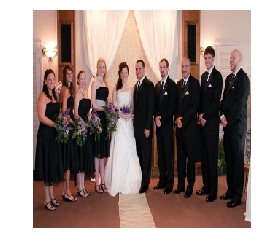

Actual Captions:
 a bridal party poses for a picture 
 a wedding party stands in the church getting their picture taken 
 a wedding photo of ten people with big smiles wearing black and white outfits
 the bridal party poses with the bride and groom  all wearing black except for the bride 
 the bride in the white dress is surrounded by the groomsmen and bridesmaids  all in black 


Predicted Captions:
a bride and groom walk past a crowd in a white canopy 


In [63]:
test_images_pred()

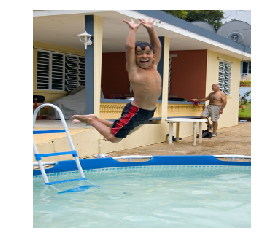

Actual Captions:
 a child is jumping into a swimming pool 
 a little boy in black shorts jumps into a backyard pool next to a yellow stucco house 
 a little boy jumps high above the swimming pool with a man in the background 
 the boy jumps into the blue pool 
 young child in midair descending into pool 


Predicted Captions:
a boy jumps into a pool 


In [37]:
test_images_pred()

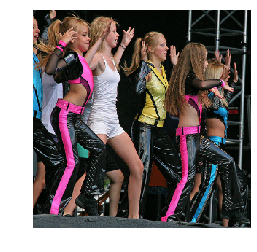

Actual Captions:
 a group of girls dancing on a stage 
 a group of teenage girls do a synchronized dance in hanna montana costumes 
 girls in a line do a dance 
 the girls are dancing and wearing leather outfits 
 young girls in dancing outfits perform on a stage 


Predicted Captions:
a group of people are dancing on the street 


In [40]:
test_images_pred()

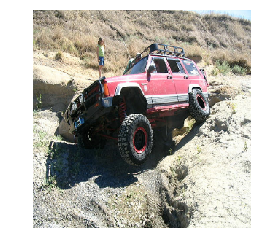

Actual Captions:
 a four wheel drive car is navigating along a rocky off road trail 
 a jeep sidewalks on some rocks 
 a red jeep hangs from the edge of a rocky cliff as a girl looks on 
 a red truck is driving over a rocky surface 
 a woman stands next to a red suv that has run off into a ditch 


Predicted Captions:
a car is driving through the mud 


In [47]:
test_images_pred()

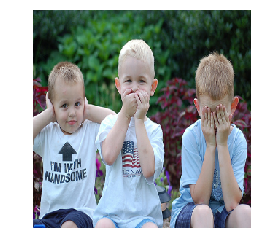

Actual Captions:
 the little boy covering his mouth is sitting between a covering his eyes and another boy covering his ears 
 three boy do  hear no evil  see no evil  speak no evil  
 three boys sit down and make gestures with their hands 
 three little boys sit together making faces 
 three young boys playing hear no evil  speak no evil  see no evil


Predicted Captions:
three young boys playing with a drum 


In [58]:
test_images_pred()

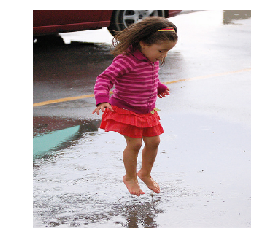

Actual Captions:
 a girl jumping in a puddle 
 a small girl jumps in a puddle 
 girl playing in a puddle with her bare feet 
 little girl jumping in water puddle
 young girl in red skirt jumping in water on a flooded street 


Predicted Captions:
a girl in a pink dress is running through the water 


In [62]:
test_images_pred()

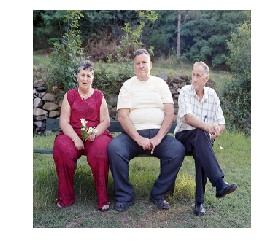

Actual Captions:
 one woman and two men on a bench 
 one woman holding flowers and two men on a bench
 three middle aged people sitting on a park bench  with a rock wall in the background 
 three people sit on a bench outside 
 two men and a woman sitting on a bench 


Predicted Captions:
three men sit on a bench in a park 


In [64]:
test_images_pred()

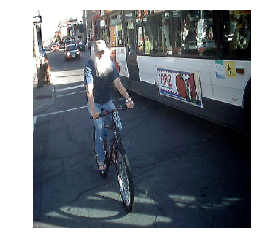

Actual Captions:
 a bearded man in jeans and a black shirt riding a bicycle in the street 
 a man with a giant white beard rides a bicycle next to a bus 
 a whitebearded man rides a bike next to a city bus 
 man with white flowing beard in jeans and tshirt riding a bike 
 the man with a white beard rides a bike near a bus 


Predicted Captions:
a man on a bicycle rides down the street 


In [72]:
test_images_pred()

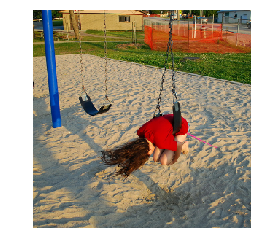

Actual Captions:
 a girl crouched up over a swing at the park  spinning around 
 a girl is kneeling on a swing at the park 
 a girl with a red shirt and long brown hair is laying across a twisted swing with sand underneath 
 a young girl in a red shirt swings face down on the swings 
 girl is playing at park on a swing 


Predicted Captions:
a child swinging on a swing 


In [104]:
test_images_pred()

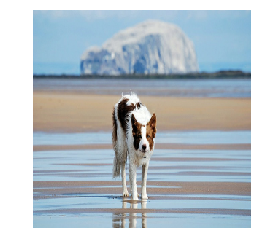

Actual Captions:
 a brown and white dog is standing in shallow water on a beach near a large rock outcrop 
 a brown and white dog on the beach 
 a dog standing on a beach 
 a dog stands on the beach with a large rock behind him 
 an unusual looking dog is standing in front of a beautiful backdrop 


Predicted Captions:
a dog is running along the beach 


In [112]:
test_images_pred()

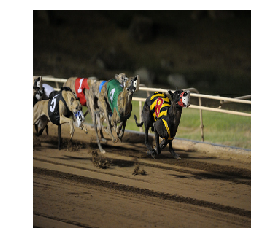

Actual Captions:
 greyhounds racing on a track
 a greyhound race with the lead dog wearing yellow and black stripes and the number 
 dogs racing at a track 
 greyhound dogs race on the track  with   leading the way 
 some greyhound dogs are racing on a dirt track 


Predicted Captions:
dogs are racing 


In [119]:
test_images_pred()

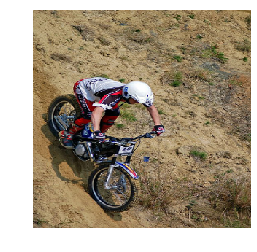

Actual Captions:
 a man riding a dirt bike in down a hill in competition 
 a motocross rider wearing red  white and black with a white helmet 
 a motorcycle racer going down a steep  dirt hill 
 a person rides a motorbike down a dirt hill 
 the man is riding a bike down a dirt hill 


Predicted Captions:
a person riding a dirt bike 


In [131]:
test_images_pred()

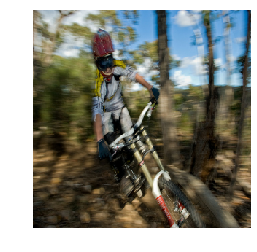

Actual Captions:
 a child wearing a helmet riding a mountain bike very fast through a forest 
 a cyclist streaks through the trees 
 a person wearing a red helmet riding a white bike 
 a person wearing a red helmet and yellow and white clothing is riding a bike outside in a wooded area 
 the bmx biker rides through the forest 


Predicted Captions:
a man in a helmet is riding a bike in the woods 


In [135]:
test_images_pred()

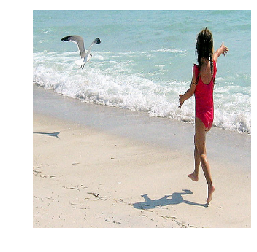

Actual Captions:
 a girl chases a bird across the sand at the edge of the ocean 
 a girl in a pink suit chases a gull on a beach 
 girl in pink bathing suit with right arm in air behind a seagull on the beach near the water 
 the little girl plays along the shoreline as the seagull passes by 
 young girl in red bathing suit feeding a seagull


Predicted Captions:
a young girl running on the beach 


In [142]:
test_images_pred()

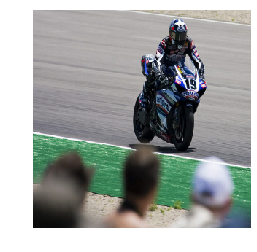

Actual Captions:
 a guy racing his motorcycle 
 a man on a motorcycle is racing at a track 
 a motorcycle goes by a crowd with its rear wheel in the air 
 person riding a racing motorcycle while other people watch 
 spectators watching a motorcyclist ground around a track 


Predicted Captions:
a man driving a motorcycle on a track 


In [154]:
test_images_pred()

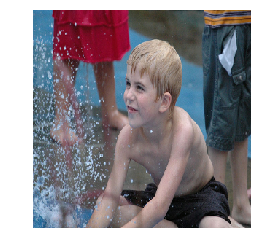

Actual Captions:
 a boy in a black swimsuit playing near the water 
 a boy is splashing water in his bathing suit 
 a little shirtless boy in shorts splashes water 
 boy in black swim trunks playing in spray of water 
 young boy splashes water at the edge of a pool 


Predicted Captions:
a young boy and a girl are playing in the water 


In [158]:
test_images_pred()

### Checking on Images outside the datasets

In [120]:
def check_images(path):
    image = load_and_preprocess_image(path)
    image = tf.expand_dims(image, 0)
    features = encoder (image)
    pred_caps = decoder.prediction(features)
    p_caps = ''
    plt.imshow(image[0].numpy())
    plt.axis('off')
    plt.show
    for idx in pred_caps:
            if idx == 0:
                break
            elif idx in [1,2,3]:
                continue
            p_caps += idx2wrd[idx]
            p_caps += ' '
    print(p_caps)

people are watching hot air balloons in the street 


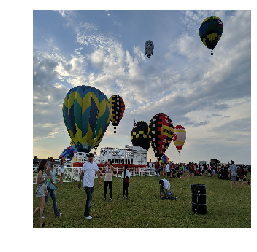

In [127]:
check_images('caps_image/test1.jpg')

a man in a yellow kayak is holding a paddle 


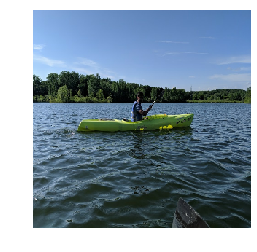

In [128]:
check_images('caps_image/test2.jpg')

a person in a red jacket is skiing down a snowy hill 


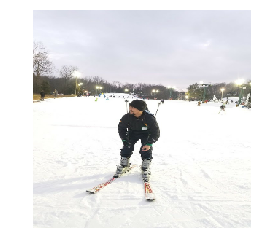

In [201]:
check_images('caps_image/test22.jpg')

a crowd of people are gathered around a track 


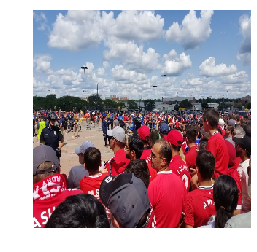

In [124]:
check_images('caps_image/test3.jpg')

a man in a blue shirt is walking on the rocks by a lake 


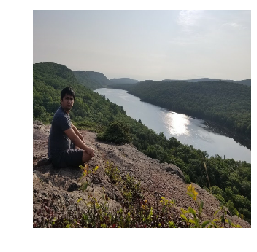

In [125]:
check_images('caps_image/test4.jpg')

a man in a red shirt is climbing a mountain 


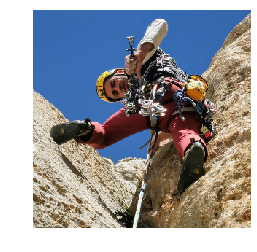

In [184]:
check_images('caps_image/test3.png')